Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

### Load Competition Data

In [1]:
# Import Statements
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import re
import num2words
%matplotlib inline
pd.options.display.max_colwidth = 750

In [2]:
# You may need to change the path
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
# Automated EDA
from pandas_profiling import ProfileReport

Report = ProfileReport(train, minimal=True).to_notebook_iframe()
Report

Summarize dataset:   0%|          | 0/11 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few leftover barrels are returned to the warehouse. Canadian Club recently pulled and vatted several of these from the 1970s. Acetone, Granny Smith apples, and fresh-cut white cedar showcase this long age. Complex and spicy, yet reserved, this dram is ripe with strawberries, canned pears, cloves, pepper, and faint flowers, then slightly pulling oak tannins. Distinct, elegant, and remarkably vibrant, this ancient Canadian Club is anything but tired. (Australia only) A$133",1
1,3861,"\nAn uncommon exclusive bottling of a 6 year old cask strength malt. Light gold in color, the nose is vegetal, more peat bog than peat smoke, with an undercurrent of pastry cream and rose. It’s an odd combination of aromas. The entry is flavorful and inviting with smoked pineapple, clove, and rose. Peak smoke arrives in full force in the mid-palate, which drops the sweet and becomes spicy. The finish is mostly smoke, but with a pleasant minty coolness. (Wyoming only)",0
2,655,"\nThis release is a port version of Amrut’s Intermediate Sherry — a sort of port pipe sandwich. The spirit is matured in both unused casks and bourbon casks, then spends a few months in port pipes, and then returns to bourbon casks. The result is a Pink Floyd show of a whisky: vibrant, colorful, complex, and nearly too much. A blackcurrant and wispy, smoky nose gives way to an intense and bittersweet mix of chili, blackcurrant, oak, damson, dark chocolate, and peat. Astounding.",1
3,555,"\nThis 41 year old single cask was aged in a sherry butt and interacted magnificently with that wood. The nose offers peeled red apples, sultanas, honey, fudge, milk chocolate, and American cream soda. Balanced and harmonious throughout, the palate yields remarkably fresh orchard fruits, pipe tobacco, black pepper, and ginger. Long in the finish, with cinnamon drying to dark chocolate, and slightly smoky, unobtrusively tannic oak. A 1970s classic!",1
4,1965,"\nQuite herbal on the nose, with aromas of dried tarragon, parsley, and dill, along with cherry, milk chocolate, orange blossom, vanilla bean, and sweet tea. The palate is slightly grain-forward, but is full and well balanced, with orange, dried flowers, chamomile tea, lemon rind, and ginger. The finish offers cinnamon and milk chocolate against a note of candied lemon. Youthful and barrel-influenced, but admirably executed.",1


In [5]:
train.shape

(4087, 3)

In [6]:
test

,id,description
0,3461,"\nStyle: Speyside single malt scotch Color: Walnut Aroma: Richly sherried and thick, with notes of nuts and toffee. Wood resins contribute spice and variety. Fruitcake at Christmas. Palate: Thick, chewy in texture, and quite ripe. Again the fruitcake. Very deep and mature with some underlying maltiness. Dry, spicy, oak notes fight off all that sherry and add balance and complexity. Long, soothing finish. \r\n"
1,2604,"\nVery bright and lively, with a nice balance of flavors. Zesty fruit (lemon, peach, ripe pineapple, golden raisin) on a bed of layered sweetness (creamy vanilla, light honey, lightly toasted marshmallow, and a hint of coconut). Gently dry, delicately spicy, dried citrus finish. Light enough and with enough zing to enjoy before dinner, but it should stand up well enough after dinner, too. This is a nice whisky, but it shows a lighter, more elegant side of Glenrothes. It doesn’t express the rich, opulent notes often shown in bottlings like the 1972 Vintage, for example."
2,3341,"\nA new oloroso-forward Chivas positioned to split between the 12 and 18 year olds? I got this. Refined and inviting nose of lemon pith, black fruits, and Kola Kubes. The velvety texture is wonderfully smooth, redolent of an apricot custard Danish, lime zest, raisin, currant, mixed peel, and walnut, with a growing bitter-lemon note. Quite unique finish, like sucking on lumpy Spanish lemons speckled with spices. (LA, NY, Miami, Chicago, Northern California, but will go national)"
3,3764,"\nAged in bourbon casks and then enhanced in Rioja wine casks. A mélange of red berry fruits, firm malt, thick vanilla and spicy oak, along with a hint of grape skin, anise, and orange peel. Gritty, dry finish."
4,2306,"\nThere is a freshness to the wood on the nose, laced with caramel and delicate minty notes. The palate pours pleasantly chewy with molten butterscotch and offers a pleasant jolt of cinnamon and clove that suggests rye at work, before settling on bitter orange peel, salted caramel, and cocoa, leading to a drying leathery and warm spice finish. Nicely done."
...,...,...
1017,2853,"\nCare for a small batch, bourbon-matured blend with a 20% malt content finished for 6 months in oloroso sherry casks? Thought so. Clementine, ripe plum, and a firm, peeled-banana nose with vanilla, warm citrus, banana, raisins, and base notes of peppery spice. There’s plenty of structure and complexity on this well-balanced blend, which ebbs away with red fruits and strawberry bubblegum. Continuously juicy, with a butter toffee and white pepper finish."
1018,219,"\nThis is the pick of the bunch, the whisky equivalent of Fountains of Wayne; an effervescent dessert whisky, which from the first aroma to the final finish is a consistent mix of vanilla, coconut, and overripe banana, sprinkled with icing sugar and cinnamon."
1019,1286,"\nPort Ellen, for sure! Very old-fashioned in nature: intertwined notes of tarry rope, coal soot, rooty peat, toffee, dark chocolate, and walnuts, spiked with coffee bean, anise, cracked peppercorn, and a hint of ginger. Dry, smoky, long, slightly austere finish. This Port Ellen is a bit moody (maybe even has an attitude problem), but I’m not complaining."
1020,2201,"\nYouthful and very lively. Bold, crisp, spices (mint, cinnamon, vanilla) are softened by soothing, sweeter notes (candied fruit, coconut, caramel, and rum notes), becoming dry, flinty, and spicy on the finish. It is very clean and polished, and it is superior to other rye whiskeys in this age range. Nicely done! \r\n"


In [7]:
target = 'ratingCategory'
features = 'description'
X = train[features]
y = train[target]

In [8]:
# Sanity Check
assert len(X) == len(y)

In [9]:
X

0       \nSometimes, when whisky is batched, a few leftover barrels are returned to the warehouse. Canadian Club recently pulled and vatted several of these from the 1970s. Acetone, Granny Smith apples, and fresh-cut white cedar showcase this long age. Complex and spicy, yet reserved, this dram is ripe with strawberries, canned pears, cloves, pepper, and faint flowers, then slightly pulling oak tannins. Distinct, elegant, and remarkably vibrant, this ancient Canadian Club is anything but tired. (Australia only) A$133
1                                                 \nAn uncommon exclusive bottling of a 6 year old cask strength malt. Light gold in color, the nose is vegetal, more peat bog than peat smoke, with an undercurrent of pastry cream and rose. It’s an odd combination of aromas. The entry is flavorful and inviting with smoked pineapple, clove, and rose. Peak smoke arrives in full force in the mid-palate, which drops the sweet and becomes spicy. The finish is mostly smoke, but wi

In [10]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    Parameters
    ----------
    text: string or object 
    Returns
    -------
    text: string or object
    """
    # order of operations - apply the expression from top to bottom
    email_regex = r"From: \S+@\S+"
    non_alpha = '[^a-zA-Z0-9’]'
    multi_white_spaces = "[ ]{2,}"
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    # To convert numbers such as, 1970s, into text. I believe these will meaningfully impact the accuracy of our models
    text = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), text)
    # apply case normalization 
    return text.lower().strip()
# If I create another version of this for the countvectorizer as opposed to the tfidvectorizer, 
# I'll have to tokenize the text. And in doing so, I can use my list comphrehension to remove any and all
# empty strings.

In [11]:
# Initializing pandarallel to speed up the tokenization process. Applying all 16 vCPUs at my disposal.
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
%%time
X = X.parallel_apply(clean_data)

CPU times: user 388 ms, sys: 219 ms, total: 607 ms
Wall time: 601 ms


In [20]:
test['description'] = test['description'].parallel_apply(clean_data)

In [16]:
# Splitting Data for Metrics
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Sanity check worked! Going back to the cell above and renaming X and y
# assert len(X_train) + len(X_val) == len(X)

In [17]:
# Establishing Baseline

baseline_acc = y.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)
# Our baseline is better than a random coinflip

Baseline Accuracy Score: 0.7057204037932089


In [18]:
X

2185    a single cask bottling of the glenrothes aged in a first fill sherry cask only five hundred and nineteen bottles all destined for the u s it is the richest chewiest sweetest and fruitiest of all the glenrothes whiskies reviewed here deep mahogany color with notes of toffee apples waxed fruit burnt orange prunes in syrup and dark chocolate the intensity of the sherry and length of oak aging gives the whisky a flavor profile that begins to transcend traditional whisky flavors expressing notes of port wine pot still rum and rancio
2463                   an essay in elegance silky and soft in texture and very clean notes of peaches and cream vanilla wafer soft honey and fruit gum drops subtler notes of tropical fruit pineapple lemon coconut demerara sugar heather and anise polished oak adds structure and contrast with a very elegant finish hard to believe this whisky is thirty two years old it s lighter and more elegant than the equally splendid highland park thirty year old which 

In [21]:
test

,id,description
0,3461,style speyside single malt scotch color walnut aroma richly sherried and thick with notes of nuts and toffee wood resins contribute spice and variety fruitcake at christmas palate thick chewy in texture and quite ripe again the fruitcake very deep and mature with some underlying maltiness dry spicy oak notes fight off all that sherry and add balance and complexity long soothing finish
1,2604,"very bright and lively with a nice balance of flavors zesty fruit lemon peach ripe pineapple golden raisin on a bed of layered sweetness creamy vanilla light honey lightly toasted marshmallow and a hint of coconut gently dry delicately spicy dried citrus finish light enough and with enough zing to enjoy before dinner but it should stand up well enough after dinner too this is a nice whisky but it shows a lighter more elegant side of glenrothes it doesn’t express the rich opulent notes often shown in bottlings like the one thousand, nine hundred and seventy-two vintage for example"
2,3341,a new oloroso forward chivas positioned to split between the twelve and eighteen year olds i got this refined and inviting nose of lemon pith black fruits and kola kubes the velvety texture is wonderfully smooth redolent of an apricot custard danish lime zest raisin currant mixed peel and walnut with a growing bitter lemon note quite unique finish like sucking on lumpy spanish lemons speckled with spices la ny miami chicago northern california but will go national
3,3764,aged in bourbon casks and then enhanced in rioja wine casks a m lange of red berry fruits firm malt thick vanilla and spicy oak along with a hint of grape skin anise and orange peel gritty dry finish
4,2306,there is a freshness to the wood on the nose laced with caramel and delicate minty notes the palate pours pleasantly chewy with molten butterscotch and offers a pleasant jolt of cinnamon and clove that suggests rye at work before settling on bitter orange peel salted caramel and cocoa leading to a drying leathery and warm spice finish nicely done
...,...,...
1017,2853,care for a small batch bourbon matured blend with a twenty malt content finished for six months in oloroso sherry casks thought so clementine ripe plum and a firm peeled banana nose with vanilla warm citrus banana raisins and base notes of peppery spice there’s plenty of structure and complexity on this well balanced blend which ebbs away with red fruits and strawberry bubblegum continuously juicy with a butter toffee and white pepper finish
1018,219,this is the pick of the bunch the whisky equivalent of fountains of wayne an effervescent dessert whisky which from the first aroma to the final finish is a consistent mix of vanilla coconut and overripe banana sprinkled with icing sugar and cinnamon
1019,1286,port ellen for sure very old fashioned in nature intertwined notes of tarry rope coal soot rooty peat toffee dark chocolate and walnuts spiked with coffee bean anise cracked peppercorn and a hint of ginger dry smoky long slightly austere finish this port ellen is a bit moody maybe even has an attitude problem but i’m not complaining
1020,2201,youthful and very lively bold crisp spices mint cinnamon vanilla are softened by soothing sweeter notes candied fruit coconut caramel and rum notes becoming dry flinty and spicy on the finish it is very clean and polished and it is superior to other rye whiskeys in this age range nicely done


### Define Pipeline Components

In [22]:
vect = TfidfVectorizer()
clf = RandomForestClassifier()

pipe = Pipeline([('vect', vect), ('clf', clf)])

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [23]:
parameters = {
    'vect__max_df': (0.75, 1.0),
    'clf__max_depth':(5,10,15,20)
}

grid_search = GridSearchCV(
                           pipe,
                           parameters,
                           cv=5,
                           n_jobs=4,
                           verbose=1
                           )

grid_search.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'clf__max_depth': (5, 10, 15, 20),
                         'vect__max_df': (0.75, 1.0)},
             verbose=1)

In [24]:
grid_search.best_params_

{'clf__max_depth': 20, 'vect__max_df': 1.0}

In [25]:
grid_search.best_score_

0.7148966660578557

In [27]:
from sklearn.metrics import accuracy_score

training_acc = accuracy_score(y, grid_search.predict(X))
val_acc = accuracy_score(y_val, grid_search.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.783114102171918
Validation Accuracy Score: 0.7017114914425427


In [36]:
model_cr = classification_report(y_val, grid_search.predict(X_val))

print(model_cr)

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       228
           1       0.70      1.00      0.82       574
           2       0.00      0.00      0.00        16

    accuracy                           0.70       818
   macro avg       0.37      0.34      0.28       818
weighted avg       0.61      0.70      0.58       818



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


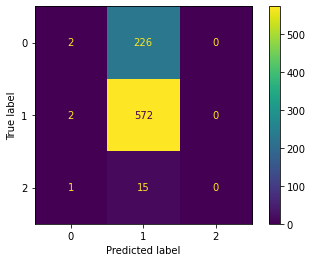

In [37]:
plot_confusion_matrix(grid_search,
                      X_val,
                      y_val,
                      values_format='.0f')

In [38]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=20))])

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [39]:
# Predictions on test sample
pred = best_model.predict(test['description'])

In [40]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [41]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [34]:
subNumber = 0

In [42]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

You're trying to achieve a minimum of 80% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD()
vect = TfidfVectorizer(stop_words="english")
clf = RandomForestClassifier()

lsi = Pipeline([('vect', vect),
                ('svd', svd)])

pipe = Pipeline([('lsi', lsi),
                 ('clf', clf)])

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [44]:
%%time

parameters = {
    'lsi__svd__n_components': [10,100,1000],
    'lsi__vect__max_df': (0.75, 1.0, 1.25),
    'clf__max_depth':(5,10,20,40)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=4, verbose=2)
grid_search.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: user 3.41 s, sys: 2.24 s, total: 5.66 s
Wall time: 4min 19s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lsi',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD())])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'clf__max_depth': (5, 10, 20, 40),
                         'lsi__svd__n_components': [10, 100, 1000],
                         'lsi__vect__max_df': (0.75, 1.0, 1.25)},
             verbose=2)

In [45]:
grid_search.best_params_

{'clf__max_depth': 10, 'lsi__svd__n_components': 10, 'lsi__vect__max_df': 1.25}

In [46]:
grid_search.best_score_

0.7320295413780669

In [48]:
from sklearn.metrics import accuracy_score

training_acc = accuracy_score(y, grid_search.predict(X))
val_acc = accuracy_score(y_val, grid_search.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8907922912205567
Validation Accuracy Score: 0.7114914425427873


In [49]:
model_cr = classification_report(y_val, grid_search.predict(X_val))

print(model_cr)

              precision    recall  f1-score   support

           0       0.51      0.16      0.24       228
           1       0.73      0.95      0.83       574
           2       0.00      0.00      0.00        16

    accuracy                           0.71       818
   macro avg       0.41      0.37      0.36       818
weighted avg       0.65      0.71      0.65       818



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


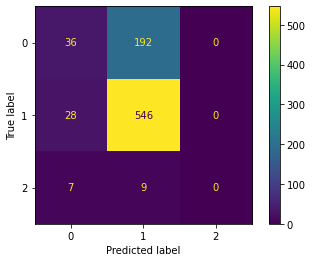

In [50]:
plot_confusion_matrix(grid_search,
                      X_val,
                      y_val,
                      values_format='.0f')

In [51]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('lsi',
                 Pipeline(steps=[('vect',
                                  TfidfVectorizer(max_df=1.25,
                                                  stop_words='english')),
                                 ('svd', TruncatedSVD(n_components=10))])),
                ('clf', RandomForestClassifier(max_depth=10))])

### Make a Submission File

In [52]:
# Predictions on test sample
pred = best_model.predict(test['description'])

In [53]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [54]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [55]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [56]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [57]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [58]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False) and (token.is_space == False)):
            lemmas.append(token.lemma_)
    
    return lemmas

In [60]:
X_lemmas = X.parallel_apply(get_lemmas)
X_lemmas

2185                                     [single, cask, bottling, glenrothe, age, fill, sherry, cask, nineteen, bottle, destine, u, s, rich, chewiest, sweet, fruity, glenrothe, whisky, review, deep, mahogany, color, note, toffee, apple, wax, fruit, burn, orange, prune, syrup, dark, chocolate, intensity, sherry, length, oak, aging, give, whisky, flavor, profile, begin, transcend, traditional, whisky, flavor, express, note, port, wine, pot, rum, rancio]
2463          [essay, elegance, silky, soft, texture, clean, note, peach, cream, vanilla, wafer, soft, honey, fruit, gum, drop, subtle, note, tropical, fruit, pineapple, lemon, coconut, demerara, sugar, heather, anise, polished, oak, add, structure, contrast, elegant, finish, hard, believe, whisky, thirty, year, old, s, light, elegant, equally, splendid, highland, park, thirty, year, old, rate, ninety, issue, bottle, exclusively, park, avenue, liquor]
2820                                                                                    

In [61]:
def listintostring(string):
    '''
    This function converts lists into strings
    '''
    str = " "
    return (str.join(string))

In [ ]:
%%time
X_lemmas_str = X_lemmas.parallel_apply(listintostring)

In [ ]:
STOP_WORDS = nlp.Defaults.stop_words

In [ ]:
tokens = []

for doc in tokenizer.pipe(X_lemmas_str):

    doc_tokens =[]

    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
    
X_tokens = tokens

In [ ]:
# Moving training labels to array
y_array = train.ratingCategory.values

In [ ]:
# Apply to your Dataset

from scipy.stats import randint

param_dist = {
    
    'lsa__svd__n_components': [10,100,1000],
    'lsa__vect__max_df': (0.75, 1.0, 1.25),
    'clf__n_estimators':[10, 100, 10],
    'clf__max_depth' : randint(5,15,30),
    'clf__min_samples_leaf': randint(2,15,2)
    }

In [ ]:
%%time
# Continue Word Embedding Work Here

#SHOULD DO MORE EDA ON DATASET TO FIGURE HOW TO TUNE PARAMETERS


svd = TruncatedSVD()
gbc = GradientBoostingClassifier()
vect = TfidfVectorizer(stop_words="english")

lsa = Pipeline([("vect", vect),
                ("svd", svd)])

pipe = Pipeline([("lsa", lsa),
                 ("clf", gbc)])

rscv = RandomizedSearchCV(
                          pipe,
                          param_dist,
                          n_iter=5,
                          cv=27,
                          n_jobs=-1,
                          verbose=1
                          )

rscv.fit(X_lemmas_str,y_array)

In [ ]:
rscv.best_params_

In [ ]:
rscv.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

training_acc = accuracy_score(y, grid_search.predict(X))
val_acc = accuracy_score(y_val, grid_search.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

In [ ]:
model_cr = classification_report(y_val, grid_search.predict(X_val))

print(model_cr)

In [ ]:
plot_confusion_matrix(grid_search,
                      X_val,
                      y_val,
                      values_format='.0f')

In [ ]:
# Use an XGBoost Classifier model after this

In [ ]:
# What are the best metrics to use to understand how well our models are performing?

# This is a classification task so the usual ones are fine: Accuracy, Precision, Recall, F1

#*I'm also using classification report, roc curve, confusion matrices, and this:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

### Make a Submission File

In [ ]:
# Predictions on test sample
pred = rscv.predict(test['description'])

In [ ]:
# I want to see the predictions themselves
list(pred)

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 80% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?